In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('/content/drive/MyDrive/trum_tweet_sentiment_analysis.csv')

In [6]:
df.head()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0


In [7]:
df.dropna()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0
...,...,...
1850118,Everytime im like 'How the fuck I follow Melan...,0
1850119,RT @imgur: The Trump Handshake. https://t.co/R...,0
1850120,"""Greenspan warns Trump's policies risk inflati...",0
1850121,RT @FasinatingLogic: We must also #INVESTIGATE...,1


In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
def text_cleaning_pipeline(dataset, rule = "lemmatize"):
  """
  This...
  """
  # Convert the input to small/lower order.
  data = dataset.lower()
  # Remove URLs
  data = re.sub(r"http\S+|www\S+|https\S+", '',data, flags=re.MULTILINE)
  # Remove emojis
  data = re.sub(r"["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags
                        u"\u2702-\u27B0"          # dingbats
                        u"\u24C2-\U0001F251"      # enclosed characters
                        "]+",
                        r' ', data, flags=re.UNICODE)
  # Remove mentions
  data = re.sub("@[A-Za-z0-9_]+"," ", data)
  # Remove all other unwanted characters.
  data = re.sub("[^0-9A-Za-z ]", "" , data)
  # Create tokens.
  tokens = data.split()
  # Remove stopwords:
  stop_words = set(stopwords.words('english'))
  result_tokens = []
  for token in tokens:
    if token not in stop_words:
      result_tokens.append(token)
  if rule == "lemmatize":
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in result_tokens]
  elif rule == "stem":
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in result_tokens]
  else:
    print("Pick between lemmatize or stem")


  return " ".join(tokens)


In [10]:
df['clean_text'] = df['text'].apply(lambda x: text_cleaning_pipeline(x, rule="lemmatize"))

In [11]:
X = df['clean_text']
y = df['Sentiment']

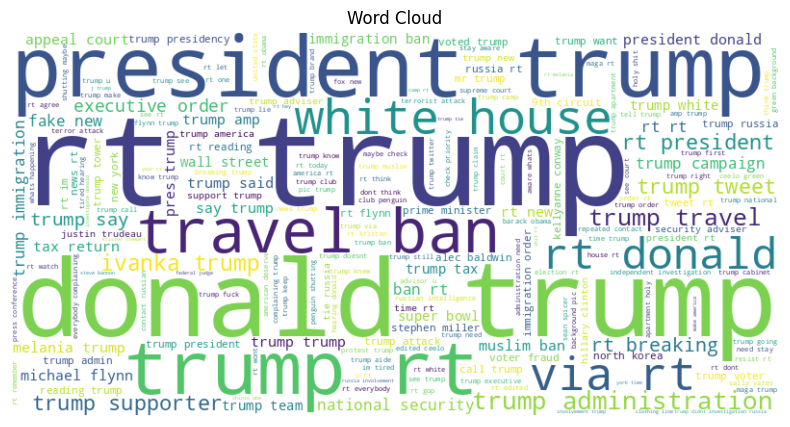

In [12]:
from wordcloud import WordCloud
all_clean_text = " ".join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_clean_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max([len(x) for x in X_train_seq])
print(max_length)


28


In [15]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=28)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=28)

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=128))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.build(input_shape=(None, 28))
rnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 28, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,292,417 (4.93 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=128))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.build(input_shape=(None, 28))
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 28, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
  from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

rnn_history = rnn_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9145 - loss: 0.2167

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - accuracy: 0.9145 - loss: 0.2167 - val_accuracy: 0.9528 - val_loss: 0.1341
Epoch 2/10
23124/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9582 - loss: 0.1222

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 134s 5ms/step - accuracy: 0.9582 - loss: 0.1222 - val_accuracy: 0.9574 - val_loss: 0.1242
Epoch 3/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.9622 - loss: 0.1114 - val_accuracy: 0.9563 - val_loss: 0.1262
Epoch 4/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 111s 5ms/step - accuracy: 0.9627 - loss: 0.1105 - val_accuracy: 0.9562 - val_loss: 0.1284
Epoch 5/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - accuracy: 0.9615 - loss: 0.1138 - val_accuracy: 0.9556 - val_loss: 0.1317
Epoch 6/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 110s 5ms/step - accuracy: 0.9603 - loss: 0.1176 - val_accuracy: 0.9511 - val_loss: 0.1415


In [18]:
lstm_history = lstm_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
23121/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9202 - loss: 0.1996

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 157s 7ms/step - accuracy: 0.9202 - loss: 0.1996 - val_accuracy: 0.9613 - val_loss: 0.1108
Epoch 2/10
23125/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9665 - loss: 0.0951

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.9665 - loss: 0.0951 - val_accuracy: 0.9684 - val_loss: 0.0913
Epoch 3/10
23126/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9748 - loss: 0.0725

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 199s 7ms/step - accuracy: 0.9748 - loss: 0.0725 - val_accuracy: 0.9711 - val_loss: 0.0856
Epoch 4/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9797 - loss: 0.0587

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 205s 7ms/step - accuracy: 0.9797 - loss: 0.0587 - val_accuracy: 0.9718 - val_loss: 0.0844
Epoch 5/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 202s 7ms/step - accuracy: 0.9830 - loss: 0.0495 - val_accuracy: 0.9724 - val_loss: 0.0863
Epoch 6/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 223s 8ms/step - accuracy: 0.9858 - loss: 0.0417 - val_accuracy: 0.9722 - val_loss: 0.0884
Epoch 7/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 179s 7ms/step - accuracy: 0.9877 - loss: 0.0356 - val_accuracy: 0.9729 - val_loss: 0.0951
Epoch 8/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 154s 7ms/step - accuracy: 0.9895 - loss: 0.0312 - val_accuracy: 0.9726 - val_loss: 0.0951


In [19]:
rnn_model.save('sagar_rnn_model.h5')

lstm_model.save('sagar_lstm_model.h5')

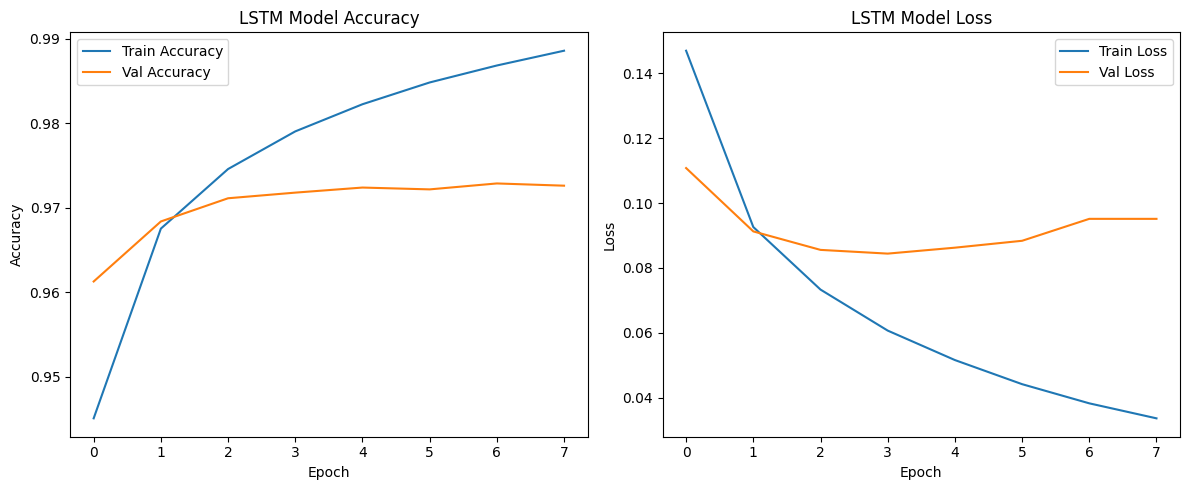

In [20]:
import matplotlib.pyplot as plt

# LSTM Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

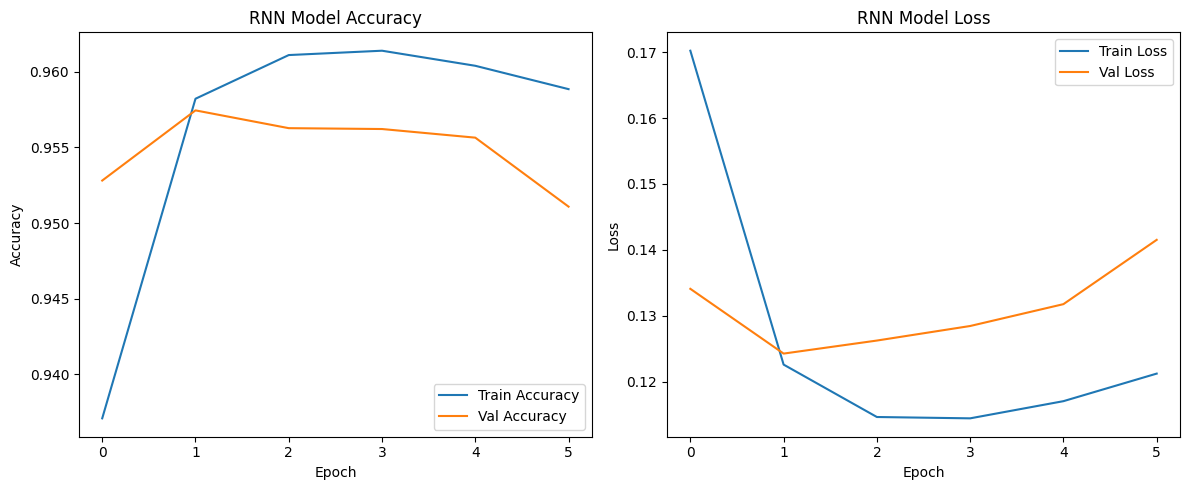

In [21]:
# RNN Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Val Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
lstm_preds = lstm_model.predict(X_test_padded)
rnn_preds = rnn_model.predict(X_test_padded)

lstm_preds_labels = (lstm_preds > 0.5).astype(int)
rnn_preds_labels = (rnn_preds > 0.5).astype(int)

y_test_labels = y_test

print("🔷 LSTM Classification Report:")
print(classification_report(y_test_labels, lstm_preds_labels))

print("🔷 RNN Classification Report:")
print(classification_report(y_test_labels, rnn_preds_labels))


11564/11564 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
🔷 LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    248563
           1       0.96      0.96      0.96    121462

    accuracy                           0.97    370025
   macro avg       0.97      0.97      0.97    370025
weighted avg       0.97      0.97      0.97    370025

🔷 RNN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    248563
           1       0.93      0.94      0.94    121462

    accuracy                           0.96    370025
   macro avg       0.95      0.95      0.95    370025
weighted avg       0.96      0.96      0.96    370025



In [23]:
from IPython.display import display
import ipywidgets as widgets
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Sample dataset of tweets (positive and negative sentiment)
tweets = [
    ("I love America and its people!", 1),
    ("This administration is doing great work.", 1),
    ("Fake news is spreading lies about me.", 0),
    ("The economy is booming like never before!", 1),
    ("Corrupt politicians are ruining our country.", 0),
    ("We will make America great again!", 1),
    ("The media hates me because I tell the truth.", 0),
    ("Our military is stronger than ever.", 1),
    ("Crooked Hillary is a disgrace to politics.", 0),
    ("Together, we can achieve greatness.", 1)
]

# Separate tweets and labels
texts, labels = zip(*tweets)

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

# Preprocess the tweets
cleaned_texts = [clean_text(text) for text in texts]

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(cleaned_texts)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")

# Create widgets
text_input = widgets.Textarea(
    placeholder="Paste Trump tweet here...",
    layout={'width': '500px', 'height': '100px'}
)
analyze_btn = widgets.Button(description="Analyze Sentiment", button_style='success')
output = widgets.Output()

def on_analyze_click(b):
    with output:
        output.clear_output()
        text = text_input.value
        if not text.strip():
            print("⚠️ Please enter a tweet!")
            return

        cleaned_text = clean_text(text)
        text_vector = tfidf.transform([cleaned_text])
        prediction = model.predict(text_vector)[0]
        # RandomForest may not return predict_proba with very small data, handle gracefully
        if hasattr(model, "predict_proba"):
            confidence = max(model.predict_proba(text_vector)[0])
            print(f"Confidence: {confidence:.2%}")
        else:
            confidence = "Unavailable"

        sentiment = "👍 POSITIVE" if prediction == 1 else "👎 NEGATIVE"
        print(f"RESULT: {sentiment}")

analyze_btn.on_click(on_analyze_click)

display(widgets.VBox([
    widgets.Label("Trump Tweet Sentiment Analysis:"),
    text_input,
    analyze_btn,
    output
]))

Model Accuracy: 50.00%
